In [ ]:
# get cluster started for parallel computation
import ncar_jobqueue
import dask
import distributed

cluster = ncar_jobqueue.NCARCluster()
client = dask.distributed.Client(cluster)

/glade/work/deppenme/miniconda3/envs/analysis/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/deppenme/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [ ]:
# adapt cluster in other cell because you don't want to start another cluster
cluster.adapt(minimum=12, maximum=40, wait_count=600)
client

Client Scheduler: tcp://10.12.205.20:34632 Dashboard: http://10.12.205.20/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### load necessary functions, modules, and data

In [ ]:
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from functions import cm2inch
import glob
import loop
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def read_dat(files, variables, pop=False):
    def preprocess(ds):
        return ds[variables].reset_coords(drop=True) # reset coords means they are reset as variables

    ds = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
    if pop==True:
        file0 = xr.open_dataset(files[0])
        ds.update(file0[['ULONG', 'ULAT', 'ULONG', 'ULAT']])
        file0.close()

    ds
    return ds

In [ ]:
# grid file
grid_p = '/glade/scratch/deppenme/POP_PROCESS/'
grid_f = 'Pac_grid_Frank.nc'
# dzt file
dzt_p = '/glade/work/deppenme/help_dir/'
dzt_f = 'Pac_dzt_t13.nc'
## dzu file
dzu_p = '/glade/work/deppenme/help_dir/'
dzu_f = 'Pac_DZU_t13.nc'
# get the infrastructure for the data, grid info and indices and such

ds_grid = xr.open_dataset(grid_p + grid_f)
ds_dzt = xr.open_dataset(dzt_p + dzt_f)
ds_dzu = xr.open_dataset(dzu_p + dzu_f)

In [ ]:
## start with tavg whole file 
#pth = '/glade/p/cgd/oce/projects/JRA55/IAF/g.e20.G.TL319_t13.control.001/ocn/tavg/'
#tavg_f = 'g.e20.G.TL319_t13.control.001_hfreq.pop.tavg.0042-0061.nc'
#ds_wf = xr.open_mfdataset([pth + tavg_f], parallel='True')

In [ ]:
# calculate with processed pacific subdomain file (maybe later check whole globe file)
sbd_pth = '/glade/scratch/deppenme/POP_PROCESS/'
sbd_tavg_f = 'Pac_g.e20.G.TL319_t13.control.001_hfreq.pop.tavg.0042-0061.nc'
ds_sbd = xr.open_mfdataset([sbd_pth + sbd_tavg_f], parallel='True')

In [ ]:
print(ds_sbd.TLAT.min().values,ds_sbd.TLONG.min().values)

-15.074753648071177 159.95


In [ ]:
print(ds_sbd.hflux_factor, ds_sbd.cp_sw, ds_sbd.cp_air, ds_sbd.rho_fw, ds_sbd.rho_sw)

<xarray.DataArray 'hflux_factor' ()>
array(2.439086e-05)
Attributes:
    long_name:  Convert Heat and Solar Flux to Temperature Flux <xarray.DataArray 'cp_sw' ()>
array(39960000.)
Attributes:
    units:      erg/g/K
    long_name:  Specific Heat of Sea Water <xarray.DataArray 'cp_air' ()>
array(1004.64)
Attributes:
    units:      joule/kg/degK
    long_name:  Heat Capacity of Air <xarray.DataArray 'rho_fw' ()>
array(1.)
Attributes:
    units:      gram/centimeter^3
    long_name:  Density of Fresh Water <xarray.DataArray 'rho_sw' ()>
array(1.026)
Attributes:
    units:      gram/centimeter^3
    long_name:  Density of Sea Water


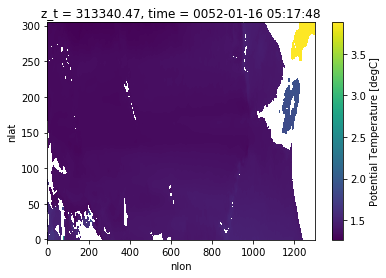

In [ ]:
ds_sbd.TEMP.isel(time=0,z_t=50).plot() # It looks like this dataset does not need masking. keep an eye on this for when it does. 

In [ ]:
ds_sbd.TEMP[0,50,0,200].values

array(nan, dtype=float32)

In [ ]:
# get indices
ULON = ds_grid.ULONG.data[:]
ULON[np.where(ULON <= 0)] = ULON[np.where(ULON <= 0)] + 360
j_eq_pop = np.abs(ds_sbd.ULAT[:,0].values).argmin(); print('ind =', j_eq_pop, '; lat =', ds_sbd.ULAT[j_eq_pop,0].values)
j_2s_pop = np.abs(ds_sbd.ULAT[:,0].values+2).argmin(); print('ind =', j_2s_pop, '; lat =',  ds_sbd.ULAT[j_2s_pop,0].values)
j_2n_pop = np.abs(ds_sbd.ULAT[:,0].values-2).argmin(); print('ind =', j_2n_pop, '; lat =',  ds_sbd.ULAT[j_2n_pop,0].values)
j_8s_pop = np.abs(ds_sbd.ULAT[:,0].values+8).argmin(); print('ind =', j_8s_pop, '; lat =',  ds_sbd.ULAT[j_8s_pop,0].values)
j_8n_pop = np.abs(ds_sbd.ULAT[:,0].values-8).argmin(); print('ind =', j_8n_pop, '; lat =',  ds_sbd.ULAT[j_8n_pop,0].values)
j_4n_pop = np.abs(ds_sbd.ULAT[:,0].values-4).argmin(); print('ind =', j_4n_pop, '; lat =',  ds_sbd.ULAT[j_4n_pop,0].values)
j_1s_pop = np.abs(ds_sbd.ULAT[:,0].values+1).argmin(); print('ind =', j_1s_pop, '; lat =',  ds_sbd.ULAT[j_1s_pop,0].values)
j_1n_pop = np.abs(ds_sbd.ULAT[:,0].values-1).argmin(); print('ind =', j_1n_pop, '; lat =',  ds_sbd.ULAT[j_1n_pop,0].values)
i_140w_pop = np.nanargmin(np.abs(ds_sbd.TLONG[j_eq_pop,:].values-220)); print('ind =', i_140w_pop, '; lon =',  ds_sbd.TLONG[j_eq_pop,i_140w_pop].values)
i_138w_pop = np.nanargmin(np.abs(ds_sbd.TLONG[j_eq_pop,:].values-222)); print('ind =', i_138w_pop, '; lon =',  ds_sbd.TLONG[j_eq_pop,i_138w_pop].values)
i_142w_pop = np.nanargmin(np.abs(ds_sbd.TLONG[j_eq_pop,:].values-218)); print('ind =', i_142w_pop, '; lon =',  ds_sbd.TLONG[j_eq_pop,i_142w_pop].values)
k_350 = np.abs(ds_sbd.z_w_bot-350e2).argmin().values; print('k=',k_350,ds_sbd.z_w_bot[k_350].values/100)

ind = 152 ; lat = 0.0
ind = 132 ; lat = -1.999623898045071
ind = 172 ; lat = 1.999623898045071
ind = 72 ; lat = -7.974611145965603
ind = 232 ; lat = 7.974611145965603
ind = 192 ; lat = 3.9968751506571416
ind = 142 ; lat = -0.999956594533917
ind = 162 ; lat = 0.999956594533917
ind = 600 ; lon = 219.95000000000002
ind = 620 ; lon = 221.95000000000002
ind = 580 ; lon = 217.95000000000002
k= 27 338.312265625


## Start calculating diathermal velocity budget

In [ ]:
%%latex
\begin{align}
w_d = \frac{ \vec{u} \cdot \nabla \theta}{|\nabla \theta|} = \frac{1}{\rho_0 c_p |\nabla \theta|} \left[ \frac{\partial I}{\partial z} + 
                                                                                                      \frac{\partial J}{\partial z} - 
                                                                                                      \nabla_h \vec{F}  \right]
    - \frac{1}{|\nabla \theta|} \frac{\partial \theta}{\partial t}
\end{align}

<IPython.core.display.Latex object>

### xr.zeros_like may be useful

In [ ]:
# grid variables
DZT = ds_dzt.DZT; print(DZT.shape)
DZU = ds_dzu.DZU; print(DZU.shape)
#DZU = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0], ds_sbd.z_w_top.shape[0])); print(DZU.shape)
#this was only for the first time to calculate this
CELL_VOL = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0], ds_sbd.z_w_top.shape[0])); print(CELL_VOL.shape)
TMASK3D = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0], ds_sbd.z_w_top.shape[0])); print(TMASK3D.shape)
UMASK3D = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0], ds_sbd.z_w_top.shape[0])); print(UMASK3D.shape)

DWORK2D = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0])); print(DWORK2D.shape)
IWORK2D = np.zeros((ds_sbd.nlon.shape[0], ds_sbd.nlat.shape[0])); print(IWORK2D.shape)

(62, 305, 1301)
(62, 305, 1301)
(1301, 305, 62)
(1301, 305, 62)
(1301, 305, 62)
(1301, 305)
(1301, 305)


(40, 40) <class 'numpy.ndarray'>


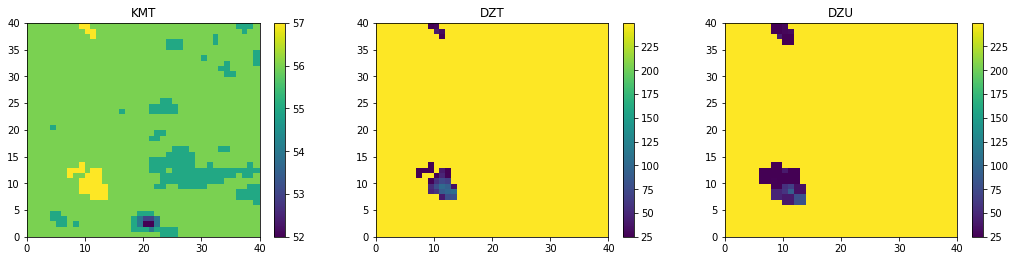

In [ ]:
tst = ds_sbd.KMT[j_2s_pop:j_2n_pop, i_142w_pop:i_138w_pop].values
print(tst.shape, type(tst))
check = tst < 61


fig, ax = plt.subplots(1,3, figsize=cm2inch(45,10))
ax[0].set_title('KMT')
kmt = ax[0].pcolormesh(tst)
plt.colorbar(kmt, ax=ax[0])

ax[1].set_title('DZT')
tkn = ax[1].pcolormesh(ds_dzt.DZT[-6,j_2s_pop:j_2n_pop, i_142w_pop:i_138w_pop].values/100)
plt.colorbar(tkn, ax=ax[1])

ax[2].set_title('DZU')
tkn = ax[2].pcolormesh(ds_dzu.DZU[-6,j_2s_pop:j_2n_pop, i_142w_pop:i_138w_pop].values/100)
plt.colorbar(tkn, ax=ax[2])

In [ ]:
#import time
# calculate DZU from DZT -> DZU is minimum of DZT around it 
#DZU_all = np.zeros_like(DZT)
#sst = time.time()
#st = time.time()
#for k in range(DZT.shape[0]):
#    tk = time.time()
#    for la in range(DZT.shape[1]-1):
#        for lo in range(DZT.shape[2]-1):
#            DZU_all[k,la,lo] = np.nanmin(DZT[k,la:la+2,lo:lo+2].values)
#    print('Level ', k, 'took', (st-tk)/60, 'Minutes')#

#print(time.time()-sst)
# write this loop in Fortran, then use f2py, also check chunking -> this is down below, check there

In [ ]:
# you never want to do that again so save it 
# dscut.to_netcdf(path=outdir+fname, mode='w', format='NETCDF4')
dzu_ds = xr.DataArray(DZU_all, coords=[ds_dzt.z_t, ds_dzt.nlat, ds_dzt.nlon], dims=['depth', 'nlat', 'nlon'])
dzu_ds.name = 'DZU'
dzu_ds.attrs['units'] = 'cm**2'
dzu_ds.to_netcdf(path='/glade/work/deppenme/help_dir/Pac_DZU_t13.nc', mode='w', format='NETCDF4')

In [ ]:
print('DZU min / max, ', np.nanmin(DZU), np.nanmax(DZU))
print('DZT min / max, ', np.nanmin(DZT), np.nanmax(DZT))

DZU min / max,  0.0 1000.0
DZT min / max,  500.0 25000.0


In [ ]:
dzt_ds = xr.DataArray(DZT, coords=[ds_dzt.z_t, ds_dzt.nlat, ds_dzt.nlon], dims=['depth', 'nlat', 'nlon'])
dzt_ds.name = 'DZT'
dzt_ds.attrs['units'] = 'cm**2'
dzt_ds.to_netcdf(path='/glade/work/deppenme/help_dir/Pac_DZT_t13.nc', mode='w', format='NETCDF4')

In [ ]:
# calculate cell volume from DZT
st = time.time()
CELL_VOL = np.zeros(DZT.shape)
for k in range(DZT.shape[0]):
    CELL_VOL[k,:,:] = DZT[k,:,:] * ds_grid.TAREA
print(time.time()-st)

0.402449369430542


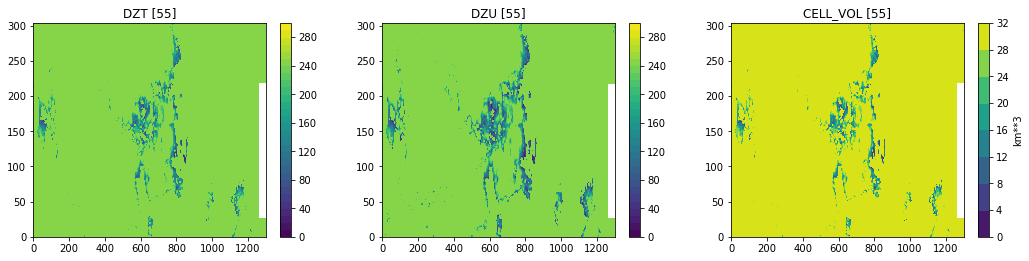

In [ ]:
fig, ax = plt.subplots(1,3, figsize=cm2inch(45,10))
ax[0].set_title('DZT [55]')
dzt = ax[0].contourf(DZT[55,:,:]/100, levels=np.arange(0,310,10))
plt.colorbar(dzt, ax=ax[0])

ax[1].set_title('DZU [55]')
dzu = ax[1].contourf(DZU[55,:,:]/100, levels=np.arange(0,310,10))
plt.colorbar(dzu, ax=ax[1])

ax[2].set_title('CELL_VOL [55]')
cv = ax[2].contourf(CELL_VOL[55,:,:]/100000/100000/100000)
cb = plt.colorbar(cv, ax=ax[2])
cb = cb.set_label('km**3')

plt.savefig('DZT_DZU_CELLVOL_55.png')

In [ ]:
# create TMASK3D
TMASK3D = np.zeros_like(DZT)
UMASK3D = np.zeros_like(DZT)

In [ ]:
for k in range(DZT.shape[0]):
    TMASK3D[k,:,:][np.where(ds_sbd.KMT >= k)] = 1
    UMASK3D[k,:,:][np.where(ds_sbd.KMU >= k)] = 1

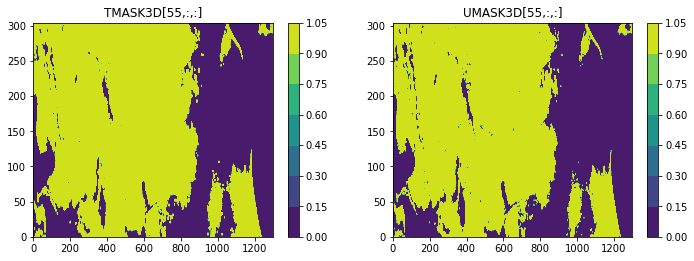

In [ ]:
fig, ax = plt.subplots(1,2, figsize=cm2inch(30,10))
ax[0].set_title('TMASK3D[55,:,:]')
tm = ax[0].contourf(TMASK3D[55,:,:])
plt.colorbar(tm, ax=ax[0])
ax[1].set_title('UMASK3D[55,:,:]')
um = ax[1].contourf(UMASK3D[55,:,:])
plt.colorbar(um, ax=ax[1])
plt.savefig('TMASK_UMASK_55.png')

In [ ]:
# make arrays for filling in calculations
V_ADV = np.zeros_like(DZT) # DZT = (k,j,i), Frank's arrays = (i,j,k)
T_ADV = np.zeros_like(DZT)

H_DIFF = np.zeros_like(DZT)
V_DIFF = np.zeros_like(DZT)
T_DIFF = np.zeros_like(DZT)

Q_SOL = np.zeros_like(DZT)

H_ADV_mean = np.zeros_like(DZT)
H_ADV_zon = np.zeros_like(DZT)
H_ADV_mer = np.zeros_like(DZT)
V_ADV_mean = np.zeros_like(DZT)
T_ADV_mean = np.zeros_like(DZT)

In [ ]:
# scale factors I will need: scale_factor (temp), cp_sw (*1e-4), rho_fw (*1e3), rho_sw (*1e3), hflux_factor, days_in_norm_year -> these are in files
# create some more scale factors to use
sec_per_day = 60*60*24; print(sec_per_day)
sec_per_year = sec_per_day*ds_sbd.days_in_norm_year.values; print(sec_per_year)
sec_per_month = sec_per_year/12.; print(sec_per_month)
scldac_w = sec_per_day/100; print(scldac_w) # cm/s -> m/day
sclfac_tend = sec_per_month; print(sclfac_tend)

86400
-5407722909013639168 nanoseconds
-450643575751136576 nanoseconds
864.0
-450643575751136576 nanoseconds


In [ ]:
# I'm not sure whether this is necessary -> get the year? 
# year = ds_sbd.time; print(year)

In [ ]:
print('TEMP min : ', np.nanmin(ds_sbd.TEMP.values), "C, TEMP max :", np.nanmax(ds_sbd.TEMP.values), 'C')
print('HMXL min : ', np.nanmin(ds_sbd.HMXL.values), "cm, HMXL max :", np.nanmax(ds_sbd.HMXL.values), 'cm')#Frank multiplius with 0.1, I don't know why? 

TEMP min :  0.5313915 C, TEMP max : 29.915548 C
HMXL min :  765.083 cm, HMXL max : 12094.043 cm


## Start calculating terms

In [ ]:
# variables I will need but don't need to load because they're available in the ds_xx :
# TEMP, HMXL (*0.01?), HBLT (*0.01?), SHF, SHF_QSW

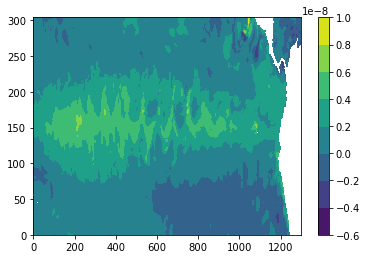

In [ ]:
# more vars to get TEND_TEMP, QSW_3D, UET
plt.contourf(ds_sbd.TEND_TEMP.isel(z_t=0,time=0))
plt.colorbar()
# it does not let me plot with TLONG and TLAT.... I don't understand why this keeps happening

### TOTAL surface flux

In [ ]:
SRF_TEMP_FLUX = (ds_sbd.SHF - ds_sbd.SHF_QSW)*ds_sbd.hflux_factor
print('Srf non sol flux between ', np.nanmin(SRF_TEMP_FLUX.values), 'and', np.nanmax(SRF_TEMP_FLUX.values)) # what should this be? 

Srf non sol flux between  -0.0057503308283469645 and -0.0016952773473838574


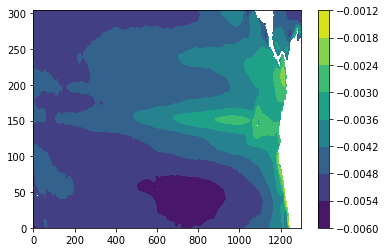

In [ ]:
plt.contourf(SRF_TEMP_FLUX[0,:,:])
plt.colorbar()

### 3D solar flux

In [ ]:
Q_SOL = np.zeros_like(ds_sbd.QSW_3D.isel(time=0))
for k in range(DZT.shape[0]-1):
    Q_SOL[k,:,:]=  (ds_sbd.QSW_3D.isel(z_w_top=k) - ds_sbd.QSW_3D.isel(z_w_top=k+1))*ds_sbd.hflux_factor / DZT[k,:,:]

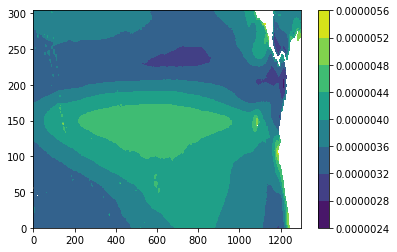

In [ ]:
plt.contourf(Q_SOL[0,:,:])
plt.colorbar()

### horizontal advection tendencies

In [ ]:
# advection tendencies H -> horizontal
uet = ds_sbd.UET.isel(time=0) * CELL_VOL
vnt = ds_sbd.VNT.isel(time=0) * CELL_VOL

U_ADV = -(uet - uet.roll(nlon=1, roll_coords='True')) / CELL_VOL
V_ADV = -(vnt - vnt.roll(nlat=1, roll_coords='True')) / CELL_VOL 

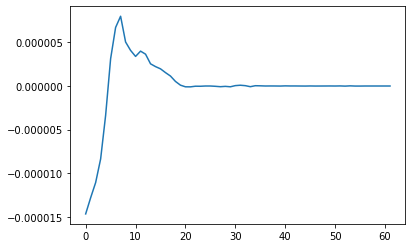

In [ ]:
H_ADV = U_ADV + V_ADV
plt.plot(H_ADV[:,163,600])

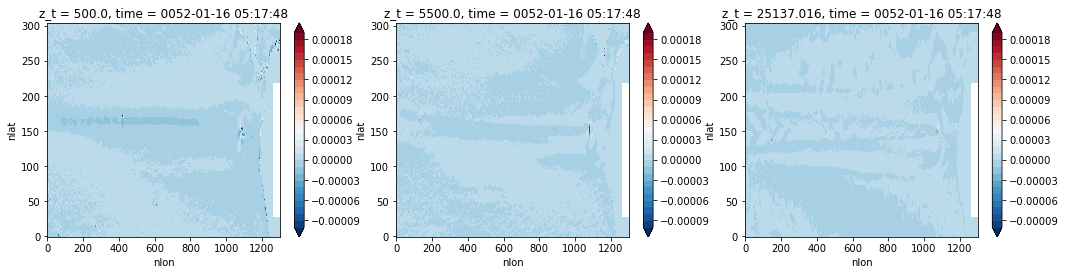

In [ ]:
fig, ax = plt.subplots(1,3, figsize=cm2inch(45,10))
H_ADV.sel(z_t=0, method='nearest').plot(levels=np.arange(-0.0001, 0.0002, 0.00001), ax=ax[0])
H_ADV.sel(z_t=50e2, method='nearest').plot(levels=np.arange(-0.0001, 0.0002, 0.00001), ax=ax[1])
H_ADV.sel(z_t=250e2, method='nearest').plot(levels=np.arange(-0.0001, 0.0002, 0.00001), ax=ax[2])
plt.savefig('horizontal_adv_POP_tavg.png')

In [ ]:
print('H_ADV min / max ', np.nanmin(H_ADV.values), np.nanmax(H_ADV.values))

H_ADV min / max  -0.0012057947746590104 0.0006615060092197783


In [ ]:
# H_ADV min / max  -0.0007307444393518381 0.0012065304108546115

### vertical advection tendency

In [ ]:
W_ADV = np.zeros_like(DZT)
for k in range(DZT.shape[0]-1):
    W_ADV[k,:,:] = -(ds_sbd.WTT.isel(time=0).isel(z_w_top=k)*ds_sbd.dz.isel(z_t=k) - ds_sbd.WTT.isel(time=0).isel(z_w_top=k+1)*ds_sbd.dz.isel(z_t=k+1))                    / DZT[k,:,:]

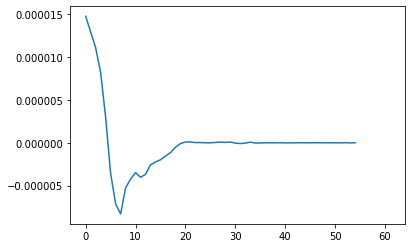

In [ ]:
plt.plot(W_ADV[:,163,600])

In [ ]:
print('WADV min, max ', np.nanmin(W_ADV), np.nanmax(W_ADV))

WADV min, max  -0.0004449892 0.0005054819


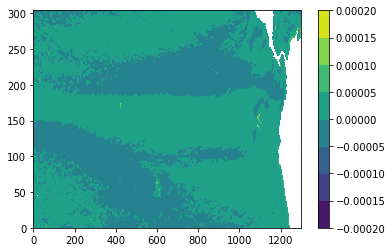

In [ ]:
plt.contourf(W_ADV[0,:,:])
plt.colorbar()

### diffusive tendencies

In [ ]:
hidffetemp = ds_sbd.HDIFE_TEMP.isel(time=0) * CELL_VOL 
hidffntemp = ds_sbd.HDIFN_TEMP.isel(time=0) * CELL_VOL 
H_DIFF_E = (hidffetemp - hidffetemp.roll(nlon=1, roll_coords='True')) / CELL_VOL
H_DIFF_N = (hidffntemp - hidffntemp.roll(nlat=1, roll_coords='True')) / CELL_VOL

In [ ]:
H_DIFF = H_DIFF_E + H_DIFF_N
print('H_DIFF min, max ', np.nanmin(H_DIFF), np.nanmax(H_DIFF))

H_DIFF min, max  -4.377644558080998e-06 5.935577419509902e-06


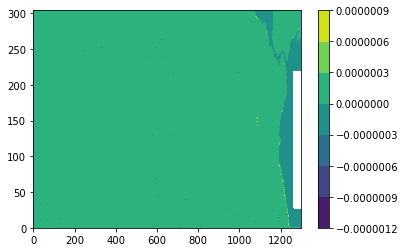

In [ ]:
plt.contourf(H_DIFF[0,:,:])
plt.colorbar()

### vertical mixing tendency

In [ ]:
V_DIFF[0,:,:] = (SRF_TEMP_FLUX[0,:,:] - ds_sbd.DIA_IMPVF_TEMP.isel(time=0, z_w_bot=0)) / DZT[0,:,:]
for k in range(1,DZT.shape[0]-1,1):
    V_DIFF[k,:,:] = ( ds_sbd.DIA_IMPVF_TEMP.isel(time=0, z_w_bot=k-1) - ds_sbd.DIA_IMPVF_TEMP.isel(time=0, z_w_bot=k)) / DZT[k,:,:]

In [ ]:
print('V_DIFF min, max ', np.nanmin(V_DIFF), np.nanmax(V_DIFF))

V_DIFF min, max  -1.4078834e-05 1.172889e-05


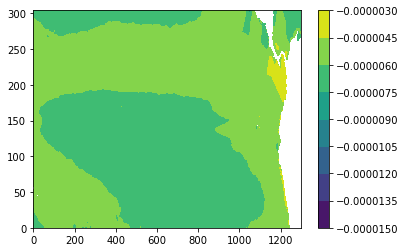

In [ ]:
plt.contourf(V_DIFF[0,:,:])
plt.colorbar()

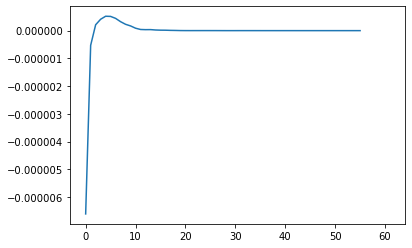

In [ ]:
plt.plot(V_DIFF[:,163,600])

### KPP source term (in the model)

In [ ]:
print('KPP_SRC min, max ', np.nanmin(ds_sbd.KPP_SRC_TEMP.isel(time=0).values), np.nanmax(ds_sbd.KPP_SRC_TEMP.isel(time=0).values))

KPP_SRC min, max  -2.3118548e-06 3.0637589e-06


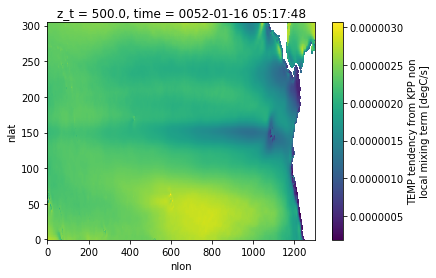

In [ ]:
ds_sbd.KPP_SRC_TEMP.isel(time=0, z_t=0).plot()

## Compute Advection by mean flow

In [ ]:
print('U min / max ', ds_sbd.UVEL.isel(time=0).min().values,ds_sbd.UVEL.isel(time=0).max().values, 'cm/s')
print('V min / max', ds_sbd.VVEL.isel(time=0).min().values,ds_sbd.VVEL.isel(time=0).max().values, 'cm/s')

U min / max  -69.69225 121.83413 cm/s
V min / max -50.462402 53.975708 cm/s


In [ ]:
ds_sbd.DYU.shape

(305, 1301)

#### zonal flow

In [ ]:
H_ADV_zon = np.zeros_like(DZT)
for k in range(DZT.shape[0]-1):
    H_ADV_zon[k,:,:] = ds_sbd.UVEL.isel(time=0,z_t=k) * ds_sbd.DYU * DZU[k,:,:] # u*dy*dz even though I don't see dz? ask Frank, maybe related to how data is stored
    
H_ADV_zon = 0.5 * (H_ADV_zon + np.roll(H_ADV_zon, 1, axis=1)) # interpolate to face (between U values)
H_ADV_zon = H_ADV_zon * 0.5 * (ds_sbd.TEMP.isel(time=0) + ds_sbd.TEMP.isel(time=0).roll(nlon=-1, roll_coords='True')) # uT
H_ADV_zon = -(H_ADV_zon - np.roll(H_ADV_zon, 1, axis=2))/ CELL_VOL # d(uT)/dy

In [ ]:
print("H_ADV_zon min / max", np.nanmin(H_ADV_zon), np.nanmax(H_ADV_zon)) # -> small??

H_ADV_zon min / max -0.0016076326887562158 0.0004472687158999507


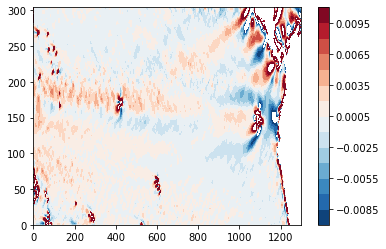

In [ ]:
plt.contourf(H_ADV_zon[0,:,:]*1000, levels=np.arange(-0.01,0.0115,0.0015), cmap='RdBu_r')
plt.colorbar()

#### meridional flow

In [ ]:
H_ADV_mer = np.zeros_like(DZT)
for k in range(DZT.shape[0]-1):
    H_ADV_mer[k,:,:] = ds_sbd.VVEL.isel(time=0,z_t=k) * ds_sbd.DXU * DZU[k,:,:] # u*dy*dz even though I don't see dz? ask Frank, maybe related to how data is stored
    
H_ADV_mer = 0.5 * (H_ADV_mer + np.roll(H_ADV_mer, 1, axis=2)) # interpolate to face (between V values)
H_ADV_mer = H_ADV_mer * 0.5 * (ds_sbd.TEMP.isel(time=0) + ds_sbd.TEMP.isel(time=0).roll(nlat=-1, roll_coords='True')) # vT
H_ADV_mer = -(H_ADV_mer - np.roll(H_ADV_mer, 1, axis=1))/ CELL_VOL # d(vT)/dx
print("H_ADV_mer min / max", np.nanmin(H_ADV_mer), np.nanmax(H_ADV_mer)) # -> small??

H_ADV_mer min / max -0.0004877833608216451 0.0005919742546412328


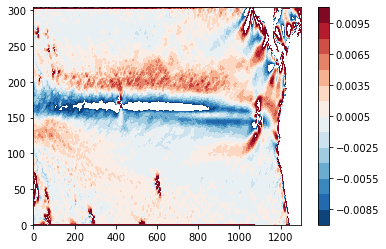

In [ ]:
plt.contourf(H_ADV_mer[0,:,:]*1000, levels=np.arange(-0.01,0.0115,0.0015), cmap='RdBu_r')
plt.colorbar()

#### total mean flow

In [ ]:
H_ADV_mean = H_ADV_zon + H_ADV_mer
print("H_ADV_mean min / max ", np.nanmin(H_ADV_mean), np.nanmax(H_ADV_mean))

H_ADV_mean min / max  -0.0016619197603489882 0.0006180189249268187


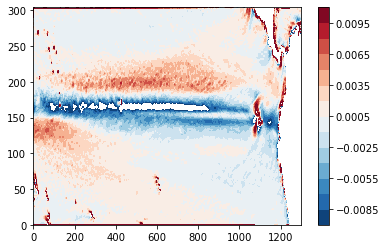

In [ ]:
plt.contourf(H_ADV_mean[0,:,:]*1000, levels=np.arange(-0.01,0.0115,0.0015), cmap='RdBu_r')
plt.colorbar()

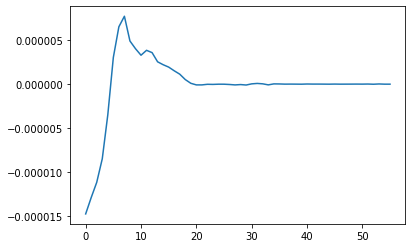

In [ ]:
plt.plot(H_ADV_mean[:,163,600])

#### vertical flow

In [ ]:
tw = np.zeros_like(V_ADV_mean)
V_ADV_mean[0,:,:] = 0.
for k in range(1,DZT.shape[0]-1,1):
    tw[k,:,:] = ds_sbd.WVEL.isel(time=0,z_w_top=k) * 0.5 * ( ds_sbd.TEMP.isel(time=0, z_t=k) + ds_sbd.TEMP.isel(time=0, z_t=k-1) )# wT

for k in range(1,DZT.shape[0]-2,1):
    V_ADV_mean[k,:,:] = -(tw[k,:,:] - tw[k+1,:,:])/DZT[k,:,:] # -d(wT)/dz
    
print("V_ADV_mean min / max ", np.nanmin(V_ADV_mean), np.nanmax(V_ADV_mean))

V_ADV_mean min / max  -0.033918846 0.037166484


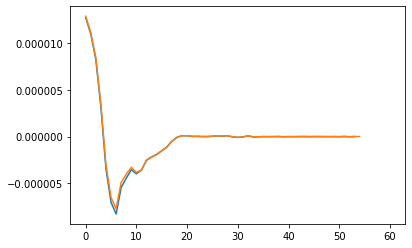

In [ ]:
plt.plot(V_ADV_mean[1:,163,600])
plt.plot(-H_ADV_mean[1:,163,600])

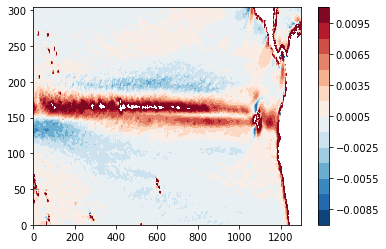

In [ ]:
plt.contourf(V_ADV_mean[1,:,:]*1000, levels=np.arange(-0.01,0.0115,0.0015), cmap='RdBu_r')
plt.colorbar()

### add the fluxes

In [ ]:
T_ADV = H_ADV + W_ADV; print('T_Adv min / max ', np.nanmin(T_ADV), np.nanmax(T_ADV))
T_ADV_mean = H_ADV_mean + V_ADV_mean; print('T_Adv_mean min / max ', np.nanmin(T_ADV_mean), np.nanmax(T_ADV_mean))
T_ADV_eddy = T_ADV - T_ADV_mean; print('T_Adv_eddy min / max ', np.nanmin(T_ADV_eddy), np.nanmax(T_ADV_eddy))

T_DIFF = H_DIFF + V_DIFF + ds_sbd.KPP_SRC_TEMP.isel(time=0).values; print('T_DIFF min / max ', np.nanmin(T_DIFF), np.nanmax(T_DIFF))
RHS = T_ADV + T_DIFF + Q_SOL; print('Right hand side min / max', np.nanmin(RHS), np.nanmax(RHS))
print('TEMP_TEND min / max', ds_sbd.TEND_TEMP.isel(time=0).min().values, ds_sbd.TEND_TEMP.isel(time=0).max().values)
ERR = ds_sbd.TEND_TEMP.isel(time=0).values - RHS; print('ERR min / max', np.nanmin(ERR), np.nanmax(ERR))

T_Adv min / max  -0.0012061941545588285 0.0006614715109346609
T_Adv_mean min / max  -0.02512638679009034 0.022040287096639445
T_Adv_eddy min / max  -0.017950720438134282 0.02512638675934295
T_DIFF min / max  -1.1715609877560595e-05 8.157499578661192e-06
Right hand side min / max -0.001206189761190806 0.0006614432543745191
TEMP_TEND min / max -1.37930956e-08 1.829874e-08
ERR min / max -0.0006614436707955001 0.0012061900900705628


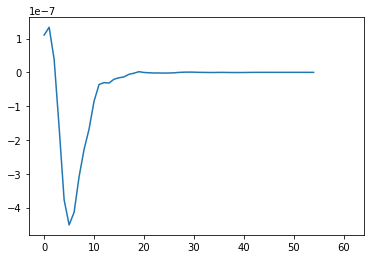

In [ ]:
plt.plot(T_ADV[:,163,600])

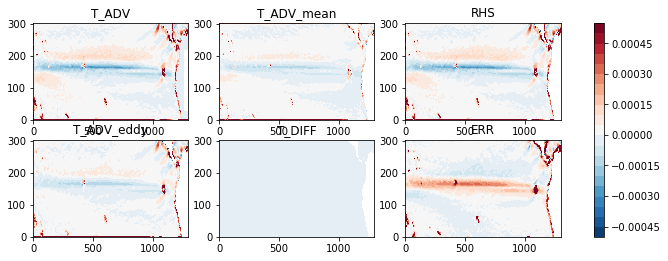

In [ ]:
fig, ax = plt.subplots(2,3, figsize=cm2inch(30,10))
tadv = ax[0,0].contourf(T_ADV[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
#plt.colorbar(tadv, ax=ax[0,0])
ax[0,0].set_title('T_ADV')

tadvm = ax[0,1].contourf(T_ADV_mean[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
#plt.colorbar(tadvm, ax=ax[0,1])
ax[0,1].set_title('T_ADV_mean')

tadve = ax[1,0].contourf(T_ADV_eddy[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
#plt.colorbar(tadve, ax=ax[1,0])
ax[1,0].set_title('T_ADV_eddy')

tdiff = ax[1,1].contourf(T_DIFF[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
#plt.colorbar(tdiff, ax=ax[1,1])
ax[1,1].set_title('T_DIFF')

trhs = ax[0,2].contourf(RHS[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
#plt.colorbar(trhs, ax=ax[0,2])
ax[0,2].set_title('RHS')

terr = ax[1,2].contourf(ERR[0,:,:]*10, levels=np.arange(-0.0005,0.00055,0.00005), cmap='RdBu_r')
plt.colorbar(terr, ax=ax[:,:])
ax[1,2].set_title('ERR')

plt.savefig('surface_tendencies_POP_tavg.png')

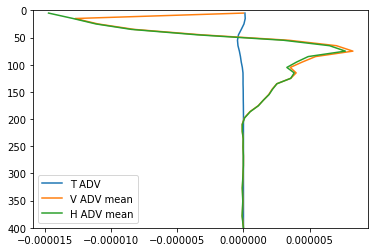

In [ ]:
# plot a vertical profile 
plt.plot(T_ADV[:,163,600], ds_sbd.z_t/100, label='T ADV')
#plt.plot(T_ADV_mean[:,163,600], ds_sbd.z_t/100, label='T ADV mean')
plt.plot(-V_ADV_mean[:,163,600], ds_sbd.z_t/100, label='V ADV mean')
#plt.plot(H_ADV_zon[:,163,600], ds_sbd.z_t/100, label='H ADV zon')
#plt.plot(H_ADV_mer[:,163,600], ds_sbd.z_t/100, label='H ADV mer')
plt.plot(H_ADV_mer[:,163,600]+H_ADV_zon[:,163,600], ds_sbd.z_t/100, label='H ADV mean')
#plt.plot(T_ADV_eddy[:,163,600], ds_sbd.z_t/100, label='T ADV eddy')
#plt.plot(T_DIFF[:,163,600], ds_sbd.z_t/100, label='T DIFF')
#plt.plot(ERR[:,163,600], ds_sbd.z_t/100, label='ERR')
plt.legend()
plt.ylim(0,400)
plt.gca().invert_yaxis()
plt.savefig('first_idea_w_contributions_POP_tavg_140W_Eq.png')

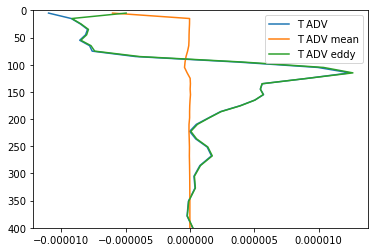

In [ ]:
plt.plot(T_ADV[:,163,600], ds_sbd.z_t/100, label='T ADV')
plt.plot(T_ADV_mean[:,163,600], ds_sbd.z_t/100, label='T ADV mean')
plt.plot(T_ADV_eddy[:,163,600], ds_sbd.z_t/100, label='T ADV eddy')
plt.legend()
plt.ylim(0,400)
plt.gca().invert_yaxis()

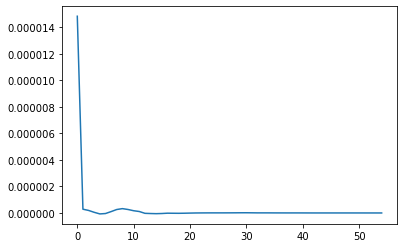

In [ ]:
T_ADV_eddy = T_ADV - T_ADV_mean
plt.plot(T_ADV_eddy[:,163,600])
#print(ds_sbd.TLAT[j_eq_pop+1,i_140w_pop].values, ds_sbd.TLONG[j_eq_pop,i_140w_pop].values)

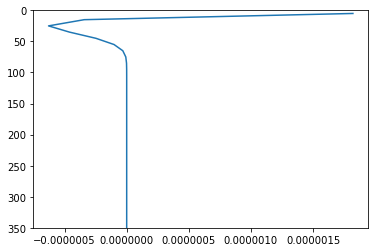

In [ ]:
plt.plot(ds_sbd.KPP_SRC_TEMP.isel(time=0,nlon=i_140w_pop,nlat=j_eq_pop+1), ds_sbd.z_t/100)
plt.ylim(0,350)
plt.gca().invert_yaxis()

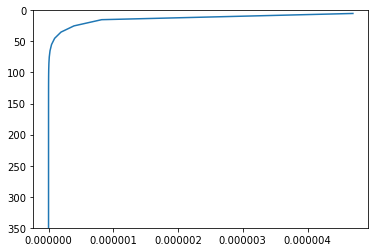

In [ ]:
plt.plot(Q_SOL[:,j_eq_pop+1,i_140w_pop], ds_sbd.z_t/100)
plt.ylim(0,350)
plt.gca().invert_yaxis()

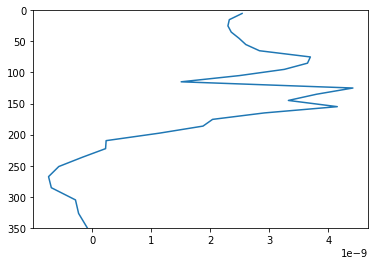

In [ ]:
plt.plot(ds_sbd.TEND_TEMP.isel(time=0,nlon=i_140w_pop,nlat=j_eq_pop), ds_sbd.z_t/100)
plt.ylim(0,350)
plt.gca().invert_yaxis()

In [ ]:
ds_sbd.TEND_TEMP

<xarray.DataArray 'TEND_TEMP' (time: 1, z_t: 62, nlat: 305, nlon: 1301)>
dask.array<shape=(1, 62, 305, 1301), dtype=float32, chunksize=(1, 62, 305, 1301)>
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 537500.0 562499.06 587499.06
    ULONG    (nlat, nlon) float64 dask.array<shape=(305, 1301), chunksize=(305, 1301)>
    TLONG    (nlat, nlon) float64 dask.array<shape=(305, 1301), chunksize=(305, 1301)>
    ULAT     (nlat, nlon) float64 dask.array<shape=(305, 1301), chunksize=(305, 1301)>
    TLAT     (nlat, nlon) float64 dask.array<shape=(305, 1301), chunksize=(305, 1301)>
  * time     (time) object 0052-01-16 05:17:48
Dimensions without coordinates: nlat, nlon
Attributes:
    grid_loc:      3111
    long_name:     Tendency of Thickness Weighted TEMP
    cell_methods:  time: mean
    units:         degC/s

## SOMETHING IS WRONG

### magnitude of temp gradient 

In [ ]:
%%latex
\begin{equation}
|\nabla \theta|
\end{equation}

<IPython.core.display.Latex object>

In [ ]:
# probably write this in fortran.. see how long this takes. started 3pm. 

gradTx = np.zeros_like(DZT)
gradTy = np.zeros_like(DZT)
gradTz = np.zeros_like(DZT)
for la in range(1,DZT.shape[1]-1,1):
    for lo in range(1,DZT.shape[2]-1,1):
        gradTz[0,la,lo] = ds_sbd.TEMP.isel(time=0, nlon=lo, nlat=la, z_t=0) - ds_sbd.TEMP.isel(time=0, nlon=lo, nlat=la, z_t=1)
        for k in range(1,DZT.shape[0]-1,1):
            gradTz[k,la,lo] = 0.5 * ( (ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k-1) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) )/ds_sbd.dzw.isel(z_w = k-1) +
                                     (ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k+1) )/ds_sbd.dzw.isel(z_w = k) )
        for k in range(0,DZT.shape[0]-2,1):
            gradTx[k,la,lo] = 0.5 * ( (ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo+1, z_t=k) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) )/ds_sbd.HUS.isel(nlon=lo, nlat=la) +
                                    (ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo-1, z_t=k) )/ds_sbd.HUS.isel(nlon=lo-1, nlat=la) 
                                    )
            gradTy[k,la,lo] = 0.5 * ( (ds_sbd.TEMP.isel(time=0, nlat=la+1, nlon=lo, z_t=k) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) )/ds_sbd.HUW.isel(nlon=lo, nlat=la) +
                                    (ds_sbd.TEMP.isel(time=0, nlat=la, nlon=lo, z_t=k) - 
                                     ds_sbd.TEMP.isel(time=0, nlat=la-1, nlon=lo, z_t=k) )/ds_sbd.HUW.isel(nlon=lo, nlat=la-1) 
                                    )

KeyboardInterrupt: 

In [ ]:
# calc mag
gradT = np.sqrt( gradTx **2 + gradTy **2 + gradTz**2)
print('gradT min / max', np.nanmin(gradT), np.nanmax(gradT))

In [ ]:
ds_sbd.dzw

<xarray.DataArray 'dzw' (z_w: 62)>
dask.array<shape=(62,), dtype=float32, chunksize=(62,)>
Coordinates:
  * z_w      (z_w) float32 0.0 1000.0 2000.0 ... 525000.94 549999.06 574999.06
Attributes:
    units:      centimeters
    long_name:  midpoint of k to midpoint of k+1

## FORTRAN INTERMEZZO

In [ ]:
# this is using the loop function to speed things up in fortran 
loop.loop?

Call signature: loop.loop(*args, **kwargs)
Type:           fortran
String form:    <fortran object>
Docstring:     
outvar = loop(var,[dimz,dimy,dimx])

Wrapper for ``loop``.

Parameters
----------
var : input rank-3 array('d') with bounds (dimz + 1,dimy + 1,dimx + 1)

Other Parameters
----------------
dimz : input int, optional
    Default: (shape(var,0)-1)
dimy : input int, optional
    Default: (shape(var,1)-1)
dimx : input int, optional
    Default: (shape(var,2)-1)

Returns
-------
outvar : rank-3 array('d') with bounds (dimz + 1,dimy,dimx)


In [ ]:
import time
# calculate DZU using the fortran loop in file loop.F90 -> this works!!!! and is much much faster than python 
# get output array
DZU_all = np.asarray(np.zeros(DZT.shape, order='F'),order='F')
# start the timer
st = time.time()
# this is where you call the loop you wrote in fortran
out_test = loop.loop(DZT)
# print how long it took 
print(time.time()-st)

0.7399542331695557


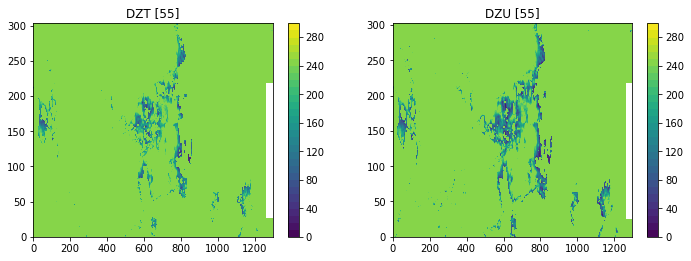

In [ ]:
fig, ax = plt.subplots(1,2, figsize=cm2inch(30,10))
ax[0].set_title('DZT [55]')
dzt = ax[0].contourf(DZT[55,:,:]/100, levels=np.arange(0,310,10))
plt.colorbar(dzt, ax=ax[0])

ax[1].set_title('DZU [55]')
dzu = ax[1].contourf(out_test[55,:,:]/100, levels=np.arange(0,310,10))
plt.colorbar(dzu, ax=ax[1])
